In [1]:
import sys

sys.path.append("../")


import polars as pl
import matplotlib.pyplot as plt

from stravalib_wrapper import *
from database import *
from time_series_parser import *
from time_series_functions import *

import numpy as np

%load_ext autoreload
%autoreload 2

## Normalized power for a fit file

In [2]:
df = get_spine(root_path="../")

In [3]:
def compute_normalized_power(filename, root_path) -> np.float64:
    try:
        ts_df = general_power_adapter(
            get_time_series(file_path=filename, root_path=root_path)
        )
        return (ts_df.filter(pl.col("fIsMoving")).select(normalized_power()))[
            "Normalized power"
        ][0]
    except pl.exceptions.ColumnNotFoundError:
        return None

In [4]:
pl.Config.set_tbl_width_chars(-1)
pl.Config.set_fmt_str_lengths(1000)

polars.config.Config

In [5]:
compute_normalized_power("fit_files/activities/17565962602.fit", "../")

203.6184796078397

In [6]:
dfnp = df.with_columns(
    pl.col("Filename")
    .map_elements(lambda f: compute_normalized_power(f, "../"), return_dtype=pl.Float64)
    .alias("Normalized power")
)

In [7]:
dfnp["Normalized power"].describe()

statistic,value
str,f64
"""count""",476.0
"""null_count""",591.0
"""mean""",195.918287
"""std""",41.237361
"""min""",0.0
"""25%""",173.212653
"""50%""",191.386813
"""75%""",205.827355
"""max""",340.516957


In [8]:
f_valid = (
    (pl.col("Normalized power") >= 50)
    & (pl.col("Normalized power").is_finite())
    & (pl.col("Distance") >= 30)
)

In [9]:
dfnp.filter(f_valid)["Normalized power"].describe()

statistic,value
str,f64
"""count""",260.0
"""null_count""",0.0
"""mean""",187.775704
"""std""",21.135556
"""min""",83.577703
"""25%""",173.807277
"""50%""",189.986071
"""75%""",202.188672
"""max""",229.768207


In [10]:
bikes = dfnp.filter(f_valid)["Activity Gear"].value_counts()

In [11]:
bikes

Activity Gear,count
str,u32
"""Bianchi Volpe""",16
"""Kreissäge""",8
"""Lauf Seigla""",154
null,1
"""Pink Bridgestone""",10
"""Trek Domane Al""",56
"""Salsa Fargo""",15


In [16]:
filters = []
for b in bikes["Activity Gear"]:
    f = pl.col("Activity Gear") == b
    filters.append((b, f))

  f = pl.col("Activity Gear") == b



In [17]:
filters

[('Bianchi Volpe',
  <Expr ['[(col("Activity Gear")) == ("B…'] at 0x7FD68DB2FA10>),
 ('Salsa Fargo', <Expr ['[(col("Activity Gear")) == ("S…'] at 0x7FD6170619D0>),
 (None, <Expr ['[(col("Activity Gear")) == (nu…'] at 0x7FD6CC39E690>),
 ('Trek Domane Al',
  <Expr ['[(col("Activity Gear")) == ("T…'] at 0x7FD60F6564D0>),
 ('Lauf Seigla', <Expr ['[(col("Activity Gear")) == ("L…'] at 0x7FD60F655850>),
 ('Kreissäge', <Expr ['[(col("Activity Gear")) == ("K…'] at 0x7FD617060190>),
 ('Pink Bridgestone',
  <Expr ['[(col("Activity Gear")) == ("P…'] at 0x7FD617063310>)]

In [18]:
markers = [
    "o",
    "^",
    "P",
    "*",
    "x",
    "d",
    "s",
]

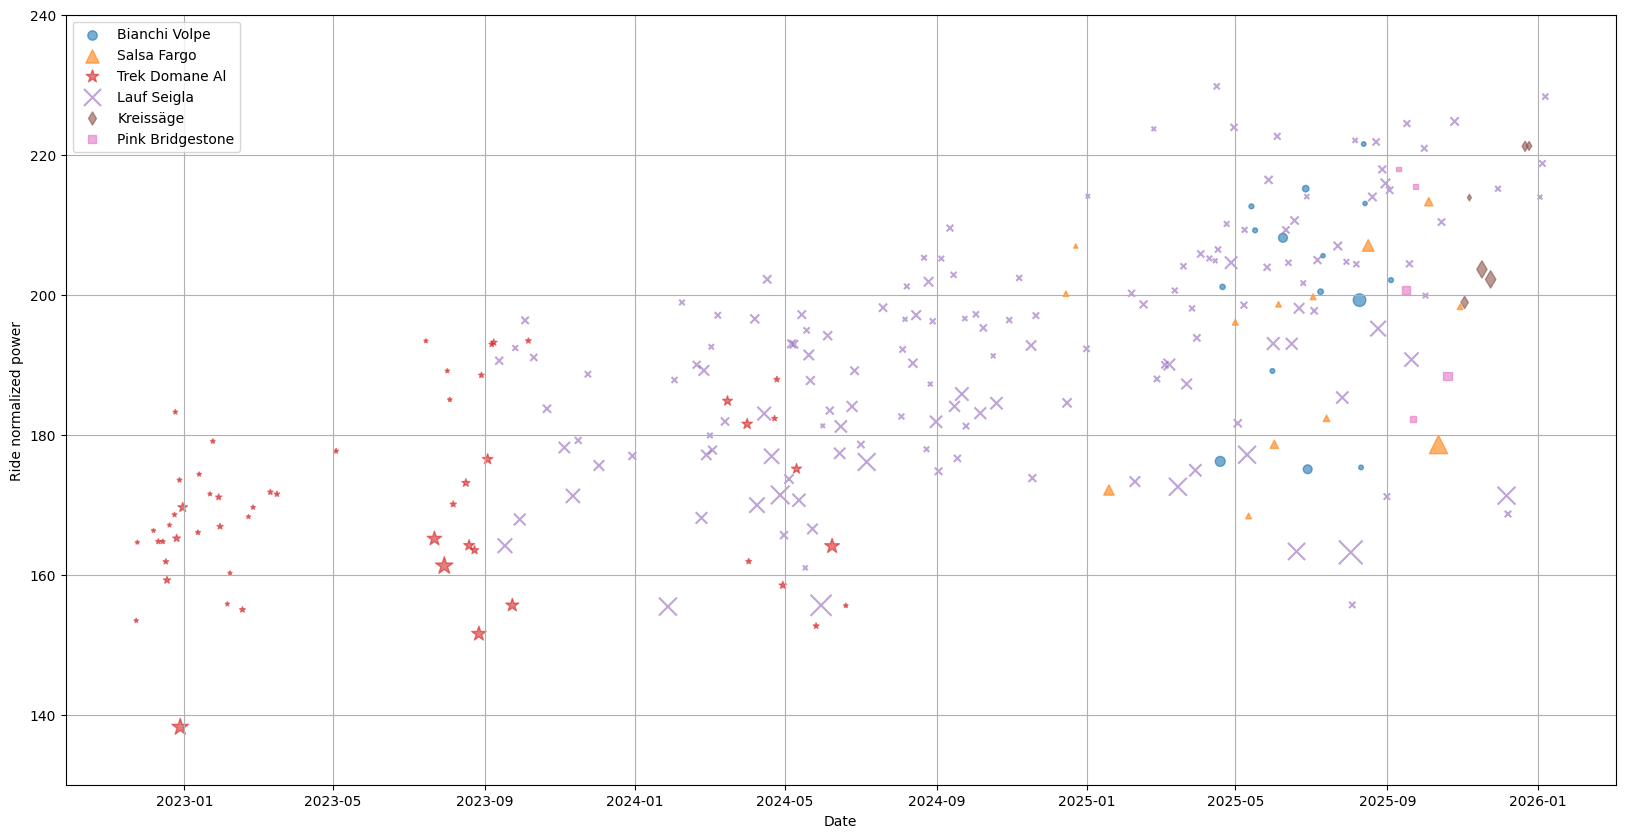

In [19]:
plt.figure(figsize=(20, 10))

for (b, f), m in zip(filters, markers):
    plt.scatter(
        dfnp.filter(f_valid & f)["Activity Date"],
        dfnp.filter(f_valid & f)["Normalized power"],
        s=(dfnp.filter(f_valid & f)["Distance"] / 20) ** 1.5 * 5,
        marker=m,
        label=b,
        alpha=0.6,
    )

plt.ylim((130, 240))
plt.legend(loc=2)

plt.xlabel("Date")
plt.ylabel("Ride normalized power")

plt.grid()

In [20]:
dfnp.filter(pl.col("Activity Gear") == "Kreissäge")

Activity ID,Activity Date,Activity Type,Activity Name,Activity Gear,Commute,Elapsed Time,Moving Time,Distance,Average Speed,Elevation Gain,Average Heart Rate,Max Heart Rate,Average Cadence,Filename,Normalized power
i64,"datetime[μs, UTC]",str,str,str,bool,i64,i64,f64,f64,f64,f64,f64,f64,str,f64
16315559197,2025-10-31 21:14:58 UTC,"""Ride""","""Commute: Afternoon Ride""","""Kreissäge""",true,2483,1137,6.25,5.504,122.0,143.0,178.0,null,"""fit_files/activities/17400542119.fit""",null
16321484244,2025-11-01 12:38:10 UTC,"""Ride""","""Tweaking the fit""","""Kreissäge""",false,3594,3371,25.81,7.659,166.0,151.0,172.0,83.0,"""fit_files/activities/17406582303.fit""",200.575493
16335010171,2025-11-02 13:20:54 UTC,"""Ride""","""Buttery Ride""","""Kreissäge""",false,17139,11403,78.8,6.911,937.0,145.0,180.0,75.0,"""fit_files/activities/17420437742.fit""",198.902682
16372805448,2025-11-06 10:38:07 UTC,"""Ride""","""Warding off the winter ennui""","""Kreissäge""",false,4547,4365,34.54,7.914,263.0,154.0,182.0,83.0,"""fit_files/activities/17458526516.fit""",213.875978
16479337874,2025-11-16 14:14:39 UTC,"""Ride""","""Perhaps it was too windy for road riding""","""Kreissäge""",false,20643,16567,123.82,7.474,1462.0,159.0,184.0,80.0,"""fit_files/activities/17565962602.fit""",203.61848
16547472482,2025-11-23 15:19:18 UTC,"""Ride""","""Marathon spectating + long ride""","""Kreissäge""",false,20492,17013,125.54,7.379,1725.0,151.0,177.0,84.0,"""fit_files/activities/17634785740.fit""",202.188672
16803861921,2025-12-21 13:16:04 UTC,"""Ride""","""Monitor +5 (outside)""","""Kreissäge""",false,8385,7260,61.43,8.462,218.0,165.0,178.0,83.0,"""fit_files/activities/17894984579.fit""",221.198709
16832503410,2025-12-24 18:32:40 UTC,"""Ride""","""The weather today was a Christmas miracle""","""Kreissäge""",false,8204,7266,52.51,7.227,859.0,156.0,178.0,83.0,"""fit_files/activities/17923957027.fit""",221.250684
17041236713,2026-01-13 22:01:49 UTC,"""Ride""","""Will riding up a hill really hard keep my fingers warm?""","""Kreissäge""",false,7279,6162,49.2306,7.989,575.0,155.4,184.0,80.9,"""fit_files/api_series_pulls/17041236713.json""",null


In [21]:
tsdf = get_time_series(
    file_path="fit_files/api_series_pulls/17041236713.json", root_path="../"
)

In [22]:
tsdf

altitude,latlng,watts,moving,temp,cadence,velocity_smooth,time,heartrate,grade_smooth,distance
f64,list[f64],i64,bool,i64,i64,f64,i64,i64,f64,f64
91.8,"[40.005088, -75.227227]",243,true,22,87,8.68,121,149,0.0,363.0
91.8,"[40.005116, -75.227131]",243,true,22,90,8.86,122,149,-0.5,372.2
91.8,"[40.005155, -75.227038]",236,true,22,92,8.98,123,150,-0.5,381.4
91.6,"[40.005191, -75.226944]",200,true,22,93,9.12,124,150,-0.5,390.7
91.6,"[40.005232, -75.226845]",128,true,22,93,9.22,125,151,-1.0,400.1
…,…,…,…,…,…,…,…,…,…,…
83.6,"[40.003348, -75.231373]",0,true,7,86,9.38,7237,152,-1.1,49041.7
83.4,"[40.003288, -75.231298]",0,true,7,0,9.26,7238,151,-0.6,49050.9
83.4,"[40.003244, -75.231211]",0,true,7,0,9.04,7239,150,-0.6,49059.3


In [23]:
(tsdf.filter(pl.col("fIsMoving")).select(normalized_power()))["Normalized power"][0]

ColumnNotFoundError: unable to find column "fIsMoving"; valid columns: ["altitude", "latlng", "watts", "moving", "temp", "cadence", "velocity_smooth", "time", "heartrate", "grade_smooth", "distance"]